# Text Classification of StackOverflow using TF-IDF Vectors

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


from definitions import TALOS_DIR
from app.preprocessing import load_dataset,preprocess_data
from app.models import load_model


Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*
6. Apply Stemmings

In [2]:
data = load_dataset(load_from_pickle=True, input_ins='as_tf_idf')
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64


## MLP classifier in Keras using not standardized tf*idf features

 ### Hyper parameter tuning for the **tf-idf** model

In [3]:
# 70% Train & 10% HeldOut & 20% Test
model_data_tf = preprocess_data(data, 'tags', 'post',
                                input_ins='as_tf_idf',
                                cv_split_full=0.2,
                                cv_split_dev=0.125)


In [14]:
'''Use the test filename if ypu don't want to delete
    # your current logs from the previous run.'''
TALOS_TF_LOG_FILENAME = 'talos_tf_log'
talos_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_TF_LOG_FILENAME)

###### Production configuration
tf_idf_model_config = {
    'visualize_proccess': [False],
    'first_neuron': [64, 128],  # First Layer
    'activation': ['relu', 'tanh'],
    'dropout': [0.2, 0.6],
    'number_of_hidden_layers': [0, 1, 2],
    'shapes':['funnel'],
    'epochs': [4, 5, 7],
    'batch_size': [32, 64],
    'model_type': ['keras_tf_idf_model'],
}

history_model_tf_idf = ta.Scan(model_data_tf['x_train'],
                               model_data_tf['y_train'],
                               x_val=model_data_tf['x_train_dev'],
                               y_val=model_data_tf['y_train_dev'],
                               model=load_model,
                               params=tf_idf_model_config,
                               grid_downsample=0.2,
                               print_params=True,
                               seed=(123),
                               dataset_name=talos_tf_log_pathname
                               )





  0%|          | 0/28 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





  4%|▎         | 1/28 [00:27<12:19, 27.39s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





  7%|▋         | 2/28 [00:44<10:28, 24.18s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 11%|█         | 3/28 [01:01<09:13, 22.12s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 14%|█▍        | 4/28 [01:28<09:25, 23.55s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 18%|█▊        | 5/28 [01:40<07:42, 20.09s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 21%|██▏       | 6/28 [02:06<08:03, 21.99s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 25%|██▌       | 7/28 [02:34<08:18, 23.75s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 29%|██▊       | 8/28 [02:51<07:13, 21.66s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 32%|███▏      | 9/28 [03:11<06:43, 21.24s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 36%|███▌      | 10/28 [03:25<05:40, 18.89s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 39%|███▉      | 11/28 [03:41<05:07, 18.08s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 43%|████▎     | 12/28 [03:59<04:50, 18.13s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 46%|████▋     | 13/28 [04:15<04:24, 17.62s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 50%|█████     | 14/28 [04:38<04:27, 19.11s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 54%|█████▎    | 15/28 [05:07<04:47, 22.10s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 57%|█████▋    | 16/28 [05:41<05:07, 25.65s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 61%|██████    | 17/28 [06:08<04:46, 26.04s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 64%|██████▍   | 18/28 [06:21<03:40, 22.06s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 68%|██████▊   | 19/28 [06:49<03:35, 23.92s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 71%|███████▏  | 20/28 [07:35<04:04, 30.60s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 75%|███████▌  | 21/28 [07:48<02:57, 25.40s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 79%|███████▊  | 22/28 [08:00<02:07, 21.31s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 82%|████████▏ | 23/28 [08:22<01:46, 21.33s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 86%|████████▌ | 24/28 [08:32<01:12, 18.20s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 89%|████████▉ | 25/28 [09:01<01:04, 21.40s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





 93%|█████████▎| 26/28 [09:18<00:39, 19.83s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_tf_idf_model'}





 96%|█████████▋| 27/28 [09:38<00:19, 19.98s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_tf_idf_model'}





100%|██████████| 28/28 [09:56<00:00, 19.36s/it]

    Finds the best model configuration set for the TF-IDF, after the Talos Scanning.

In [15]:
report_tf = ta.Reporting(history_model_tf_idf)
best_model_idx = report_tf.data['val_f1'].idxmax()
best_model_params = report_tf.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 4,
 'val_loss': 0.566318606376648,
 'val_f1': 0.8114174718856811,
 'val_categorical_accuracy': 0.81475,
 'loss': 0.23301610878109932,
 'f1': 0.8569716288021633,
 'categorical_accuracy': 0.9262857142857143,
 'visualize_proccess': 'False',
 'first_neuron': 128,
 'activation': 'tanh',
 'dropout': 0.2,
 'number_of_hidden_layers': 1,
 'shapes': 'funnel',
 'epochs': 4,
 'batch_size': 32,
 'model_type': 'keras_tf_idf_model'}

    Trains and fit the MLP Network  using the best selected features.

In [16]:
model_tf_history, model_tf = load_model(model_data_tf['x_train'],
                                        model_data_tf['y_train'],
                                        model_data_tf['x_train_dev'],
                                        model_data_tf['y_train_dev'],
                                        best_model_params)

### Visualize Model History Scores

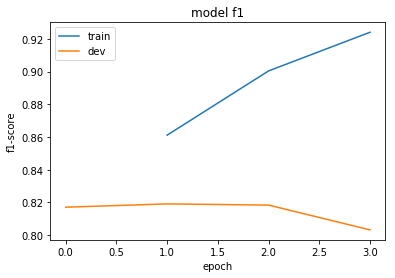

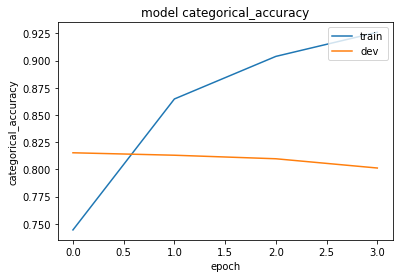

In [17]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt

%matplotlib inline
plot_history_metrics(history_obj=model_tf_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [18]:
score_tf = model_tf.evaluate(model_data_tf['x_test'],
                             model_data_tf['y_test'],
                             batch_size=best_model_params['batch_size'],
                             verbose=1)

print('\nTest f1: %.4f' % (score_tf[1]))
print('\nTest categorical accuracy: %.4f'% (score_tf[2]))

8000/8000 [==============================] - 0s 50us/step

Test f1: 0.8020

Test categorical accuracy: 0.7951


### Visualize Prediction Perfomance of **non-standardized** TF-IDF  model

--------------------------------------------------------------------------------
Accuracy Score: 79.51%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.727     0.605     0.660       400
           1      0.907     0.905     0.906       400
           2      0.977     0.960     0.968       400
           3      0.811     0.770     0.790       400
           4      0.863     0.868     0.865       400
           5      0.563     0.690     0.620       400
           6      0.834     0.777     0.805       400
           7      0.835     0.825     0.830       400
           8      0.621     0.743     0.677       400
           9      0.625     0.682     0.652       400
          10      0.696     0.630     0.661       400
          11      0.829     0.863     0.846       400
       

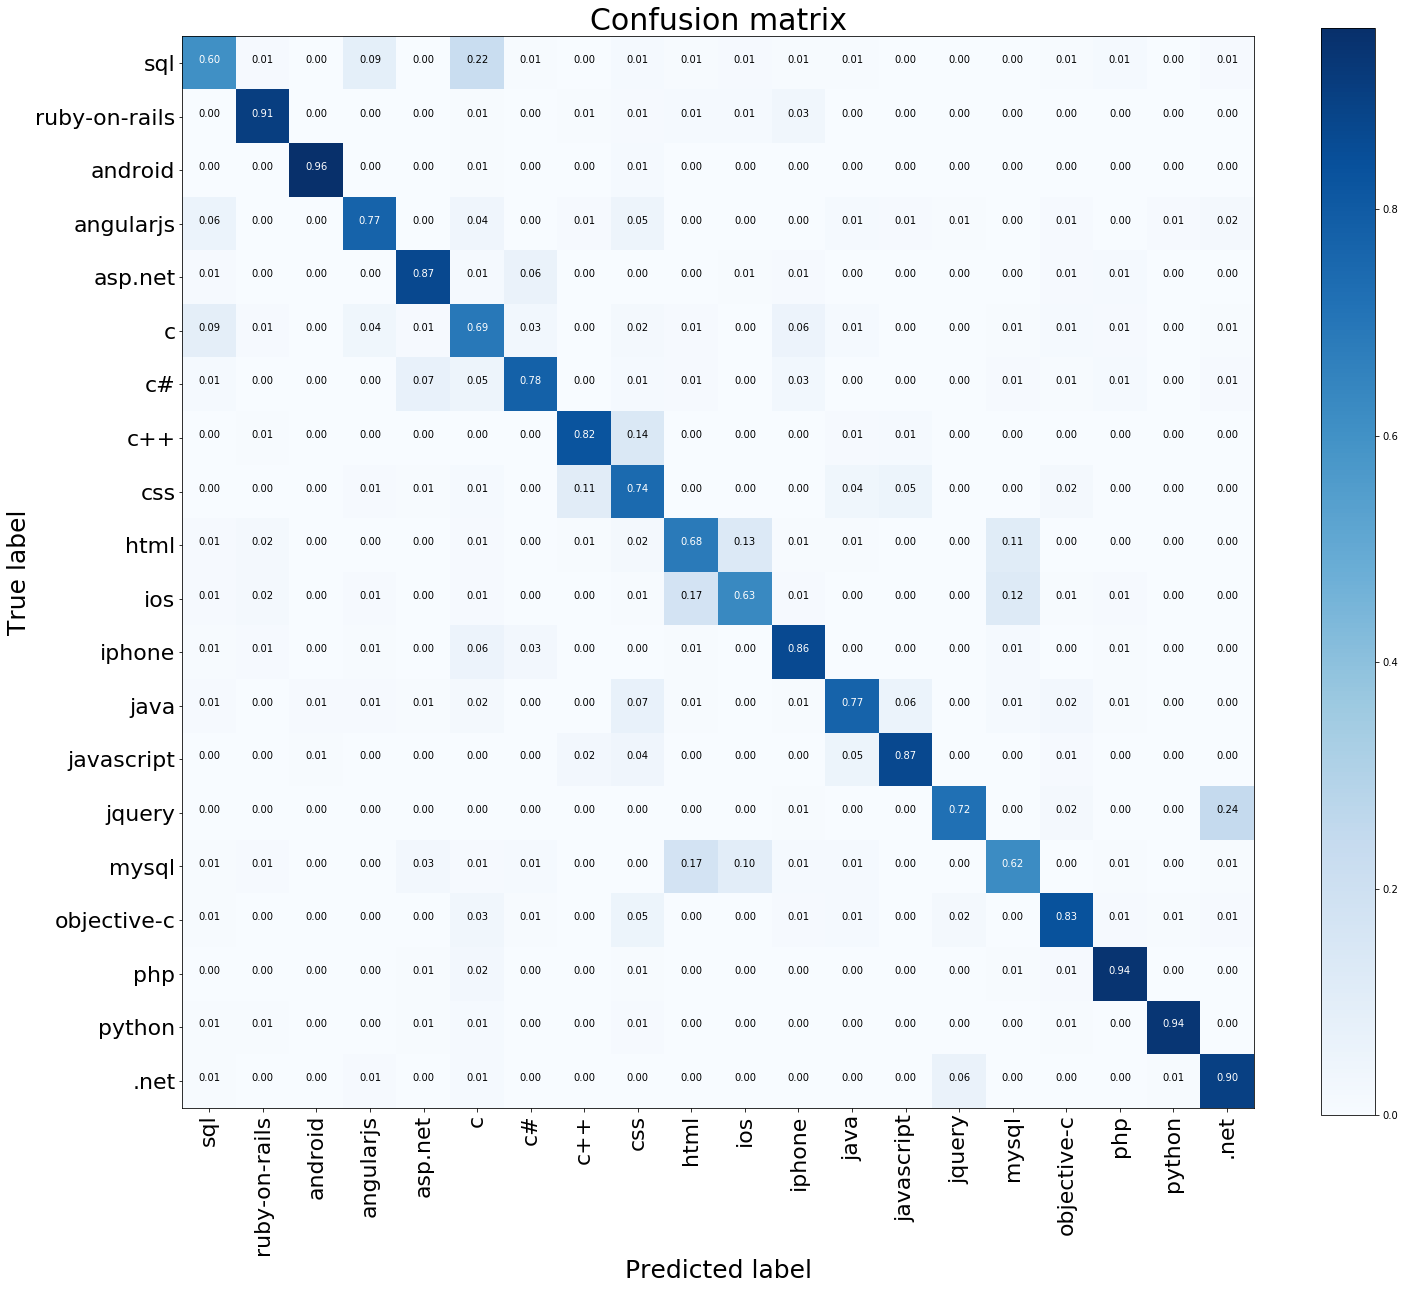

In [19]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_tf = model_tf.predict(model_data_tf['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_tf = np.array([np.argmax(val) for val in prediction_val_tf])
y_true_processed_tf = np.array([np.argmax(val) for val in model_data_tf['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data_tf['y_test'], prediction_val_tf, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data_tf['y_test'], prediction_val_tf, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_tf, y_pred_processed_tf, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_tf, y_pred_processed_tf, Classes)

## MLP classifier in Keras using standardized tf*idf features

In [20]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
model_data_sdr_tf = preprocess_data(data, 'tags', 'post',
                                    input_ins='as_tf_idf',
                                    cv_split_full=0.2,
                                    cv_split_dev=0.125,
                                    standarize=True
                                    )

In [27]:
TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log'
talos_sdr_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_TF_LOG_FILENAME)

tf_idf_sdr_model_config = tf_idf_model_config.copy()
tf_idf_sdr_model_config.update({
    'model_type': ['keras_sdr_tf_idf_model']
})

##### Production configuration
history_model_sdr_tf_idf = ta.Scan(model_data_sdr_tf['x_train'],
                                   model_data_sdr_tf['y_train'],
                                   x_val=model_data_sdr_tf['x_train_dev'],
                                   y_val=model_data_sdr_tf['y_train_dev'],
                                   model=load_model,
                                   params=tf_idf_sdr_model_config,
                                   grid_downsample=0.2,
                                   print_params=True,
                                   seed=(123),
                                   dataset_name=talos_sdr_tf_log_pathname
                                   )





  0%|          | 0/28 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





  4%|▎         | 1/28 [00:29<13:11, 29.33s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





  7%|▋         | 2/28 [00:47<11:15, 25.97s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 11%|█         | 3/28 [01:08<10:15, 24.63s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 14%|█▍        | 4/28 [01:44<11:12, 28.03s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 18%|█▊        | 5/28 [01:55<08:44, 22.81s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 21%|██▏       | 6/28 [02:24<09:04, 24.77s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 25%|██▌       | 7/28 [03:12<11:04, 31.63s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 29%|██▊       | 8/28 [03:40<10:11, 30.55s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 32%|███▏      | 9/28 [03:54<08:03, 25.47s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 36%|███▌      | 10/28 [04:15<07:14, 24.14s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 39%|███▉      | 11/28 [04:50<07:47, 27.47s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 43%|████▎     | 12/28 [05:20<07:32, 28.26s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 46%|████▋     | 13/28 [05:49<07:07, 28.49s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 50%|█████     | 14/28 [06:24<07:06, 30.49s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 54%|█████▎    | 15/28 [06:52<06:25, 29.68s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 57%|█████▋    | 16/28 [07:20<05:49, 29.16s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 61%|██████    | 17/28 [07:48<05:18, 28.92s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 64%|██████▍   | 18/28 [07:59<03:53, 23.34s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 68%|██████▊   | 19/28 [08:16<03:15, 21.67s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 4, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 71%|███████▏  | 20/28 [08:36<02:47, 20.95s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 75%|███████▌  | 21/28 [09:07<02:49, 24.18s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 79%|███████▊  | 22/28 [09:30<02:21, 23.59s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 82%|████████▏ | 23/28 [10:24<02:43, 32.72s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 86%|████████▌ | 24/28 [10:37<01:47, 26.96s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'relu', 'dropout': 0.6, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 89%|████████▉ | 25/28 [11:10<01:25, 28.67s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





 93%|█████████▎| 26/28 [11:52<01:05, 32.86s/it]

{'visualize_proccess': False, 'first_neuron': 64, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 7, 'batch_size': 64, 'model_type': 'keras_sdr_tf_idf_model'}





 96%|█████████▋| 27/28 [12:12<00:28, 28.87s/it]

{'visualize_proccess': False, 'first_neuron': 128, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 5, 'batch_size': 32, 'model_type': 'keras_sdr_tf_idf_model'}





100%|██████████| 28/28 [12:51<00:00, 31.96s/it]

In [22]:
report_sdr_stf = ta.Reporting(history_model_sdr_tf_idf)
best_model_sdr_idx = report_sdr_stf.data['val_f1'].idxmax()
best_model_sdr_params = report_sdr_stf.data.loc[best_model_sdr_idx].to_dict()
best_model_sdr_params

{'round_epochs': 4,
 'val_loss': 0.5590486302375793,
 'val_f1': 0.8101421761512756,
 'val_categorical_accuracy': 0.82,
 'loss': 0.2568078661305564,
 'f1': 0.8489223514965603,
 'categorical_accuracy': 0.9195,
 'visualize_proccess': 'False',
 'first_neuron': 128,
 'activation': 'tanh',
 'dropout': 0.2,
 'number_of_hidden_layers': 1,
 'shapes': 'funnel',
 'epochs': 4,
 'batch_size': 64,
 'model_type': 'keras_sdr_tf_idf_model'}

In [23]:
model_sdr_tf_history, model_sdr_tf = load_model(model_data_sdr_tf['x_train'],
                                                model_data_sdr_tf['y_train'],
                                                model_data_sdr_tf['x_train_dev'],
                                                model_data_sdr_tf['y_train_dev'],
                                                best_model_sdr_params)

### Visualize Model History Scores

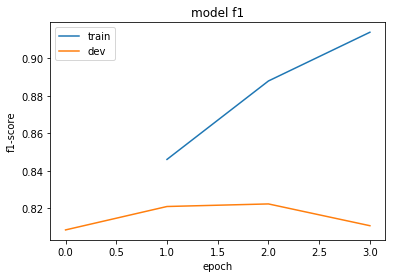

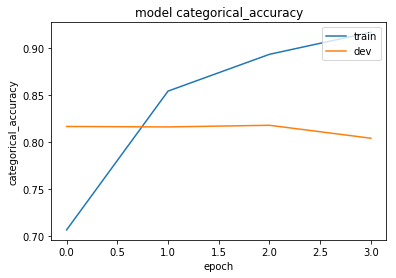

In [24]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt
%matplotlib inline

plot_history_metrics(history_obj=model_sdr_tf_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [25]:
score_sdr_tf = model_sdr_tf.evaluate(model_data_sdr_tf['x_test'],
                                     model_data_sdr_tf['y_test'],
                                     batch_size=best_model_sdr_params['batch_size'],
                                     verbose=1)

print('\nTest f1: %.4f' % (score_sdr_tf[1]))
print('\nTest categorical accuracy: %.4f'% (score_sdr_tf[2]))

8000/8000 [==============================] - 0s 36us/step

Test f1: 0.8055

Test categorical accuracy: 0.7945


### Visualize Prediction Perfomance of **standardized** TF-IDF  model

--------------------------------------------------------------------------------
Accuracy Score: 79.45%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.708     0.618     0.660       400
           1      0.883     0.905     0.894       400
           2      0.965     0.970     0.968       400
           3      0.800     0.750     0.774       400
           4      0.863     0.850     0.856       400
           5      0.563     0.713     0.629       400
           6      0.772     0.795     0.783       400
           7      0.847     0.845     0.846       400
           8      0.698     0.670     0.684       400
           9      0.664     0.608     0.634       400
          10      0.655     0.682     0.668       400
          11      0.851     0.843     0.847       400
       

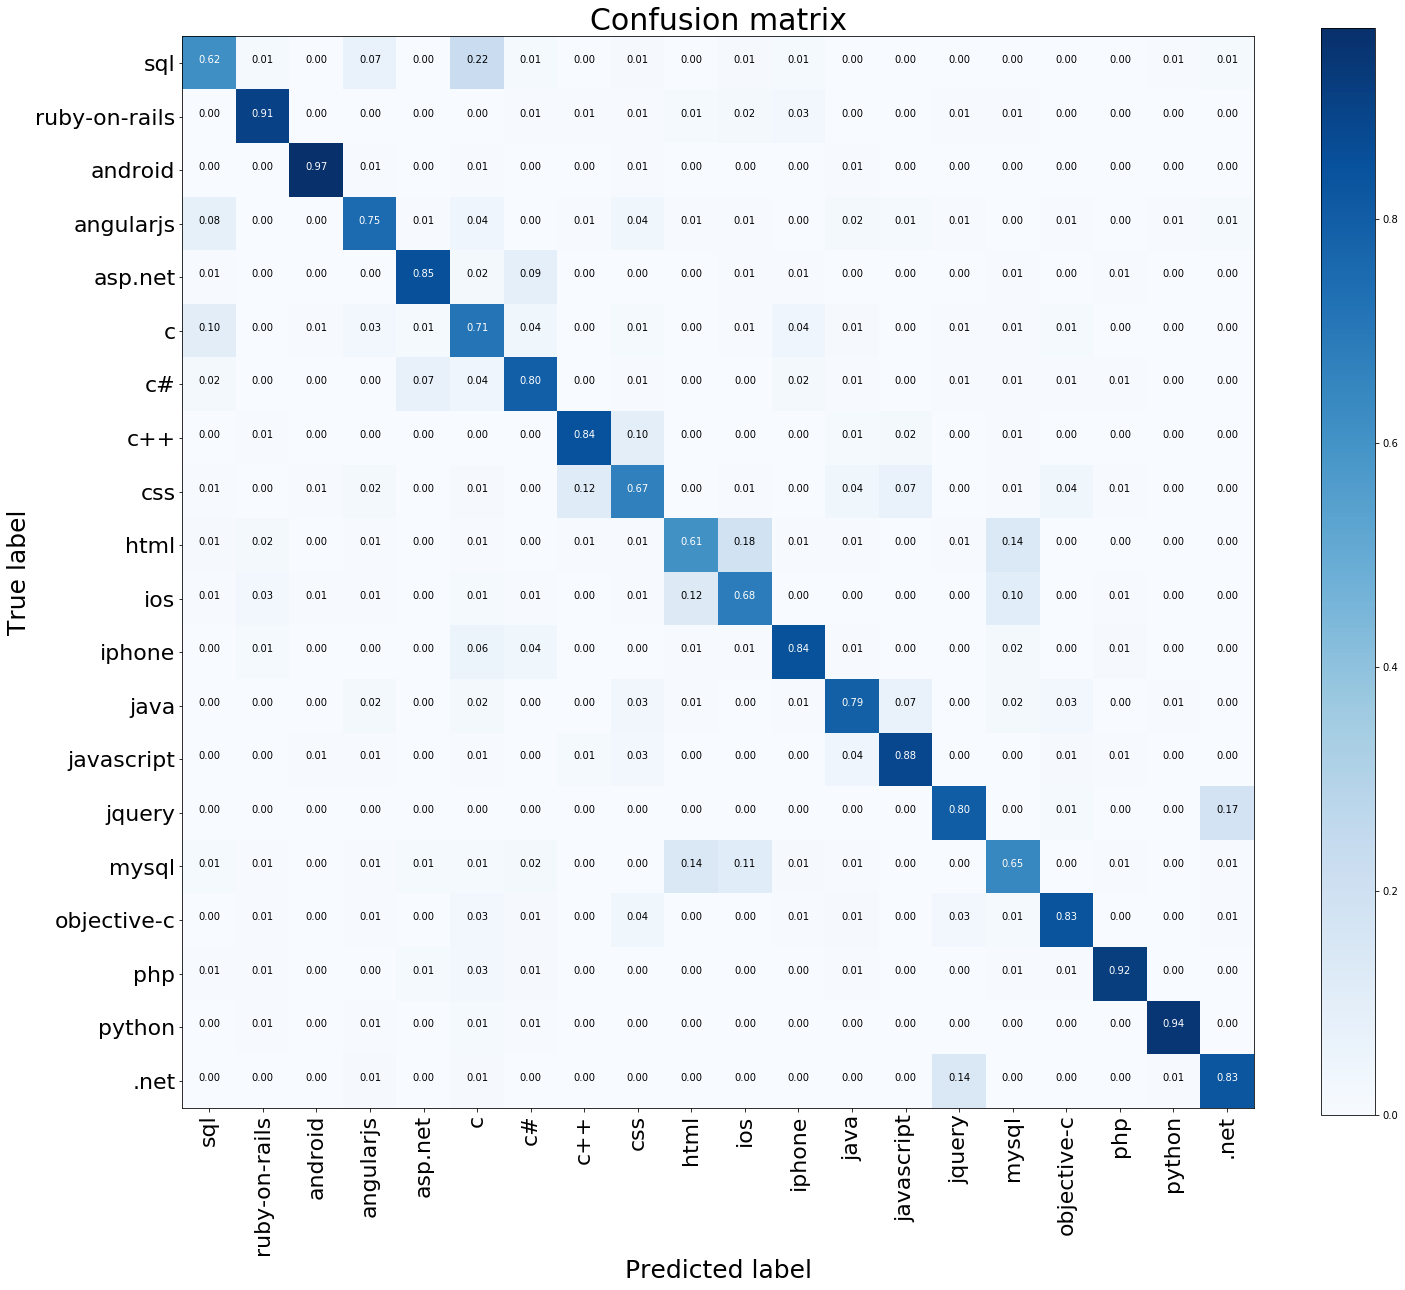

In [26]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_sdr_tf = model_sdr_tf.predict(model_data_sdr_tf['x_test'],
                                             batch_size=best_model_sdr_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_sdr_tf = np.array([np.argmax(val) for val in prediction_val_sdr_tf])
y_true_processed_sdr_tf = np.array([np.argmax(val) for val in model_data_sdr_tf['y_test']])

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_sdr_tf, y_pred_processed_sdr_tf , Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_sdr_tf, y_pred_processed_sdr_tf , Classes)